In [1]:
# Importando os módulos que serão utilizados

import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import time
import dill

# Configurando o acesso do tensorflow aos processadores do computador
# no caso, está sendo selecionada a primeira placa de vídeo listada

gpus = tf.config.experimental.list_physical_devices('GPU') # Listando as placas de vídeo
tf.config.experimental.set_memory_growth(gpus[0], True)    # Selecionando a primeira GPU e configurando

# Importando os módulos contendo as funções criadas no projeto

from aux_func_V3 import *
import API_Numpy
import API_TensorFlow

In [2]:
with open('datasets\\Dados temporais Tatiana transp.bkp','rb') as file:
     Δx=2/128
     CFL=0.5
     Δt=0.4/100
     fronteria=FronteiraPeriodica
     y=dill.load(file)
     equation=transp_equation
# with open('datasets\\Dados temporais 4.bkp','rb') as file:
#      data_dict=dill.load(file)
#      y=data_dict['data']
#      Δx=data_dict['Δx']*data_dict['granul_x']
#      CFL=0.5
#      Δt=data_dict['Δt']*data_dict['granul_t']
#      fronteria=data_dict['Fronteira']

In [3]:
y.shape

(150, 101, 128)

In [4]:
print(Δt**3)
print(Δx**5)

6.4e-08
9.313225746154785e-10


In [5]:
def loop_wrapper(func):
    def loop_func(u0,Δx):
        u=u0+0
        for i in range(y.shape[1]-1):
            u=func(u,Δx)
        return u
    return loop_func

In [6]:
Sim, Sim_step, DerivadaEspacial, Get_weights=create_simulation(API_Numpy,burgersequation_equation,WENO_Z)
WENO_Z_ref=lambda u0, Δx:Sim(u0,Δt, Δx, CFL, fronteria)
Sim, Sim_step, DerivadaEspacial, Get_weights=create_simulation(API_Numpy,equation,WENO_JS)
WENO_JS_ref=lambda u0, Δx:Sim(u0,Δt, Δx, CFL, fronteria)# Criando uma camada de Burgers que integra o WENO à rede neural
Sim_layer = WENO_temporal(Δx, CFL, Δt, fronteria,equation,WENO_Z,regul_weight=0,ativ_func=tf.nn.sigmoid,p=2)
WENO_network=tf.function(lambda u0, Δx:Sim_layer.Sim(u0,Δt, Δx, CFL, fronteria))

In [7]:
# Sim, Sim_step, DerivadaEspacial, Get_weights=create_simulation(API_Numpy,burgers_equation,WENO_Z)
# WENO_Z_ref=lambda u0, Δx, Δt:Sim(u0,Δt, Δx, CFL, FronteiraPeriodica)
# Sim, Sim_step, DerivadaEspacial, Get_weights=create_simulation(API_Numpy,burgers_equation,WENO_JS)
# WENO_JS_ref=lambda u0, Δx, Δt:Sim(u0,Δt, Δx, CFL, FronteiraPeriodica)
# # Criando uma camada de Burgers que integra o WENO à rede neural
# Sim_layer = WENO_temporal(Δx, CFL, Δt, FronteiraFixa,burgers_equation,WENO_JS,regul_weight=0)
# WENO_network=tf.function(lambda u0, Δx, Δt:Sim_layer.Sim(u0,Δt, Δx, CFL, FronteiraPeriodica))

In [7]:
indice = np.arange(y.shape[0])
np.random.shuffle(indice)
data_x = y.astype('float64')[indice]
data_y = y.astype('float64')[indice]

In [8]:
data_y.shape

(150, 101, 128)

In [ ]:
# plt.figure(figsize=(6.4*5,6.4*2))
# for i,j in zip(range(5),np.random.randint(0,50,5)):
#     plt.subplot(2, 5, i%5+1)
#     plt.ylim(-2,2)
#     plt.plot(data_x[j,0])
#     plt.subplot(2, 5, 5+i%5+1)
#     plt.ylim(-2,2)
#     plt.plot(data_y[j,100])
# plt.savefig('tatiana dataset.png')

In [9]:
# Conjunto de dados de treino
# train_x = data_x[:-40,:-1]
# train_y = data_x[:-40,1:]
# k=10
# data_cutted=np.split(data_x,np.arange(k+1,data_x.shape[1],k+1),axis=1)
# data_cutted=np.concatenate([i for i in data_cutted if i.shape[1]==k+1],axis=0)
train_x = data_x[:,:-1]
train_y = data_y[:,1:]

# test_x = data_x[-5000:]
# test_y = data_y[-5000:]

# Conjunto de dados de validação
# test_x = data_x[-40:,:-1]
# test_y = data_x[-40:,1:]

In [10]:
# Definindo o input da rede e o otimizador de treino
input_x   = keras.layers.Input(train_x.shape[1:], dtype='float64')
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# ouput_x=input_x
# ouput_list=[]
# for i in range(train_y.shape[1]):
#     ouput_x=Sim_layer(ouput_x)
#     ouput_list.append(ouput_x+0)
# final_x=tf.stack(ouput_list,axis=1)

timely_layer=keras.layers.TimeDistributed(Sim_layer)
final_x=timely_layer(input_x)

# final_x=Sim_layer(input_x)

# Criando a rede neural
Network = keras.Model(input_x, final_x)
# Configurando a função de perda e o otimizador

def metric( y_true, y_pred):
        """
        Função que avalia o custo dado um valor de referência e um valor previsto
        --------------------------------------------------------------------------
        y_true (tensor): valor de referência
        y_pred (tensor): valor predito
        --------------------------------------------------------------------------
        loss   (tensor): custo associado
        --------------------------------------------------------------------------
        """
        y_true = tf.cast(y_true, y_pred.dtype) # Convertendo os tipos para evitar conflitos
        
        loss = tf.reduce_mean(
            tf.math.abs(y_pred - y_true)
            )
        
        return tf.math.log(loss)/np.log(10)

class MES_OF(k.losses.Loss):
    """Criando uma função de custo cuja superclasse é a de funções de
    custo do keras"""
    
    def call(self, y_true, y_pred):
        return metric(y_true, y_pred)

Network.compile(loss='MSE', optimizer=optimizer, metrics=['mean_absolute_error',metric])

In [15]:
# Treinando a rede neural
history=Network.fit(
            train_x                           , # Dados de treino
            train_y                           , # Dados de treino
#            validation_data = (test_x, test_y), # Dados de validação
            batch_size      = 4            , # Tamanho do batch
            epochs          = 90            , # Número de epochs
#            steps_per_epoch = 90             , # Número de batchs por epoch
            shuffle         = True              # Aleatorização dos batchs
        )

# Batch: pacote de dados utilizados antes de uma atualização dos pesos da rede
# Epoch: rodada de treino da rede neural, em geral percorre todo o conjunto de dados

Epoch 1/90
38/38 [==============================] - 54s 1s/step - loss: 6.0665e-04 - mean_absolute_error: 0.0015 - metric: -2.8998
Epoch 2/90
38/38 [==============================] - 61s 2s/step - loss: 6.0662e-04 - mean_absolute_error: 0.0015 - metric: -2.9134
Epoch 3/90
38/38 [==============================] - 63s 2s/step - loss: 6.0649e-04 - mean_absolute_error: 0.0015 - metric: -2.9016
Epoch 4/90
38/38 [==============================] - 57s 2s/step - loss: 6.0626e-04 - mean_absolute_error: 0.0015 - metric: -2.8974
Epoch 5/90
38/38 [==============================] - 52s 1s/step - loss: 6.0616e-04 - mean_absolute_error: 0.0015 - metric: -2.8926
Epoch 6/90
38/38 [==============================] - 58s 2s/step - loss: 6.0616e-04 - mean_absolute_error: 0.0015 - metric: -2.8991
Epoch 7/90
38/38 [==============================] - 63s 2s/step - loss: 6.0616e-04 - mean_absolute_error: 0.0015 - metric: -2.9355
Epoch 8/90
38/38 [==============================] - 64s 2s/step - loss: 6.0613e-04 

In [12]:
print(np.mean(np.abs(WENO_Z_ref(train_x,Δx)-train_y)))
print(np.mean(np.abs(WENO_network(train_x,Δx)-train_y)))

0.001628409923062773
0.0015131048814076404


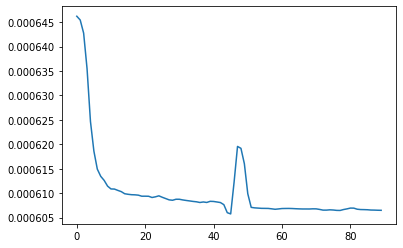

In [13]:
plt.plot(history.history['loss'])

In [14]:
# Salvando os pesos treinados
save=input('Deseja salvar a rede?(Y/N)')
if save=='Y':
    Network.save_weights('Modelos treinados\\Modelo Rede temporal - 5.h5')

In [27]:
# Carregando os pesos treinados
Network.load_weights('Modelos treinados\\Modelo Rede temporal p=1 - 1.h5')

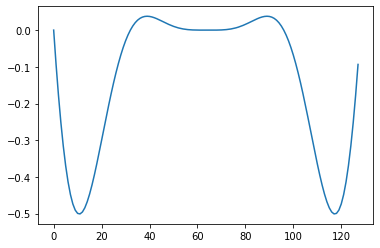

In [11]:
f_test = lambda x: np.sin(2*pi*x)*x**3 #np.exp(-0.05*(x**2))
plt.plot(f_test(tf.range(-1, 1, Δx, dtype=float_pres)))

In [12]:
0.001**3

1e-09

In [13]:
(20/100)**5

0.0003200000000000001

In [17]:
Δt=0.001
Δt=0.4/1000

equation=equation

def loop_wrapper(func):
    def loop_func(u0,Δx):
        u=u0+0
        #for i in range(int(1/Δt)):
        for i in range(100):
            u=func(u,Δx)
        return u
    return loop_func

Sim_Z, Sim_step_Z, DerivadaEspacial_Z, Get_weights_Z=create_simulation(API_Numpy,equation,WENO_Z)
WENO_Z_ref=loop_wrapper(lambda u0, Δx:Sim_step_Z(u0,Δt, Δx, FronteiraPeriodica))
Sim_JS, Sim_step_JS, DerivadaEspacial_JS, Get_weights_JS=create_simulation(API_Numpy,equation,WENO_JS)
WENO_JS_ref=loop_wrapper(lambda u0, Δx:Sim_step_JS(u0,Δt, Δx, FronteiraPeriodica))
# Criando uma camada de Burgers que integra o WENO à rede neural
Sim_layer = WENO_temporal(Δx, CFL, Δt, FronteiraPeriodica,equation,WENO_Z,regul_weight=0)
WENO_network=loop_wrapper(tf.function(lambda u0, Δx:Sim_layer.Sim_step(u0,Δt, Δx, FronteiraPeriodica)))

In [18]:
# Definindo o input da rede e o otimizador de treino
input_x   = keras.layers.Input([train_x.shape[1],train_x.shape[2]], dtype='float64')
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

ouput_x=input_x
# ouput_list=[]
# for i in range(train_y.shape[1]):
#     ouput_x=Sim_layer(ouput_x)
#     ouput_list.append(ouput_x+0)
# final_x=tf.stack(ouput_list,axis=1)

timely_layer=keras.layers.TimeDistributed(Sim_layer)
final_x=timely_layer(ouput_x)

# Criando a rede neural
Network = keras.Model(input_x, final_x)
# Configurando a função de perda e o otimizador

Network.compile(loss='MSE', optimizer=optimizer, metrics=['mean_absolute_error'])

In [37]:
# Carregando os pesos treinados
Network.load_weights('Modelos treinados\\Modelo Rede temporal - 3.h5')

In [38]:
#np.random.seed(seed=13031998)
n=1

z1=np.random.uniform(size=[n,1],low=1,high=2)
z2=np.random.uniform(size=[n,1],low=10,high=30)
z3=np.random.uniform(size=[n,1],low=1,high=2)

In [39]:
def f_test(x):
    x_ref=x+1
    #f1=np.where(x_ref<1,z1,0) 
    f2=-np.exp(-z2*((x_ref-1)**2))
    #f3=z3*np.sin(np.pi*x_ref) 

    y=np.concatenate([f2],axis=0)
    return y

In [40]:
# Calculando os erros de previsão utilizando o WENO-Z em uma malha mais fina 
# como solução de referência e depois calculando o WENO-Z e o WENO-Z com a 
# modificação da rede neural numa malha mais grossa
sizes=np.arange(100,160+1,20)
error1=[]
error2=[]
error3=[]
k=10
for i in sizes:
    print(i,end='\r')
    Δx_ref = 2/i
    Δx = Δx_ref                                # Distância espacial dos pontos na malha mais grossa utilizada
    x  = tf.range(-1, 1, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional
    full_U=tf.expand_dims(f_test(x),axis=0)

    net_u   = WENO_network(full_U,Δx)
    comp_u   = WENO_Z_ref(full_U,Δx)
    JS_u   = WENO_JS_ref(full_U,Δx)

    Δx = Δx_ref/k                                # Distância espacial dos pontos na malha mais grossa utilizada
    x  = tf.range(-1, 1, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional
    full_U=tf.expand_dims(f_test(x),axis=0)

    ref_u   = WENO_Z_ref(full_U,Δx)
    ref_u   = tf.gather(ref_u,np.arange(net_u.shape[-1])*k,axis=-1) 

    error1.append(np.sum(np.abs(net_u-ref_u)))
    error2.append(np.sum(np.abs(comp_u-ref_u)))
    error3.append(np.sum(np.abs(JS_u-ref_u)))
error1=np.asarray(error1)
error2=np.asarray(error2)
error3=np.asarray(error3)

In [15]:
erro1=np.mean(np.abs(Sim_step_Z(train_x,0.4/100,2/128,FronteiraPeriodica)-train_y))
erro2=np.mean(np.abs(Sim_layer.Sim_step(train_x,0.4/100,2/128,FronteiraPeriodica)-train_y))

print(erro1)
print(erro2)

NameError: name 'Sim_step_Z' is not defined

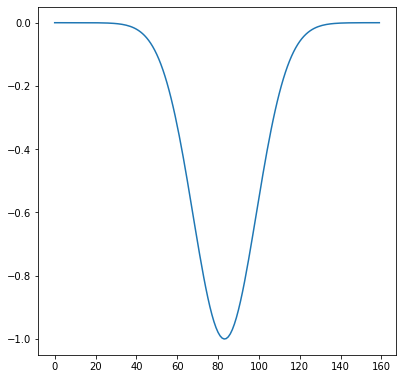

In [41]:
#plt.plot(net_u[0,0])
plt.figure(figsize=(6.4,6.4))
plt.plot(ref_u[0,0])
plt.savefig('imagens/ordem conv ds funcao.png')

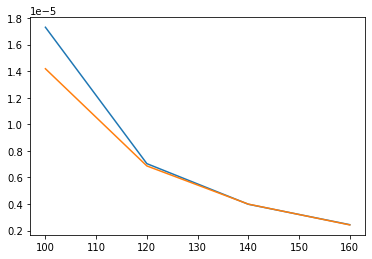

In [42]:
plt.plot(sizes,error1)
plt.plot(sizes,error2)

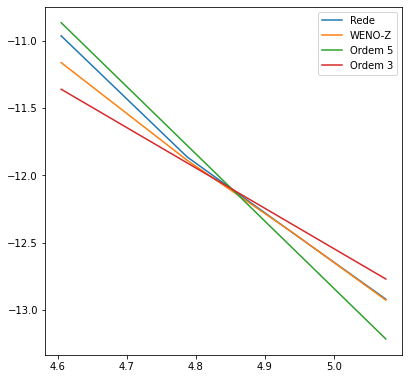

In [43]:
plt.figure(figsize=(6.4,6.4))

plt.plot(np.log(sizes),np.log(error1),label='Rede')
plt.plot(np.log(sizes),np.log(error2),label='WENO-Z')
#plt.plot(np.log(sizes),np.log(error3),label='WENO-JS')
plt.plot(np.log(sizes),-5*(np.log(sizes)-np.mean(np.log(sizes)))+np.mean(np.log(error2)),label='Ordem 5')
plt.plot(np.log(sizes),-3*(np.log(sizes)-np.mean(np.log(sizes)))+np.mean(np.log(error2)),label='Ordem 3')
plt.legend()

plt.savefig('imagens/ordem conv ds.png')

In [ ]:
Sim, Sim_step, DerivadaEspacial, Get_weights=create_simulation(API_Numpy,equation,WENO_Z)
WENO_Z_ref=lambda u0, Δx:DerivadaEspacial(u0,Δx, FronteiraFixa)

In [16]:
Δx_ref = 0.01

def f(x):
    return np.sin(np.pi*x)

def df(x):
    return np.pi*np.cos(np.pi*x)


In [17]:
Δx1 = Δx_ref
x1  = np.arange(-1, 1, Δx1)
x1  = np.expand_dims(x1,0)
u1  = f(x1)
du1 = df(x1)
y1=WENO_network(u1, Δx1)

print(u1.shape)

(1, 200)


In [18]:
Δx2 = Δx_ref/2
x2  = np.arange(-1, 1, Δx2)
x2  = np.expand_dims(x2,0)
u2  = f(x2)
du2 = df(x2)
y2=WENO_network(u2, Δx2)

print(u2.shape)

(1, 400)


In [19]:
# Gerando os gráficos a partir de funções do matplotlib

print(np.sum(abs(y1 - du1))/np.sum(abs(y2 - du2)))

0.49998867338114705
